In [1]:
import csv
import numpy as np
import configparser
import matplotlib.pyplot as plt

from keras.utils import np_utils
from sklearn.decomposition import PCA

Using TensorFlow backend.
/opt/conda/envs/music_clasification/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/music_clasification/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/music_clasification/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/m

In [2]:
config = configparser.ConfigParser()
config.read('project/config/config-docker.ini')

['project/config/config-docker.ini']

In [3]:
import sys
sys.path.insert(0, 'project/')
print(sys.path)

['project/', '/opt/notebooks', '/opt/conda/envs/music_clasification/lib/python37.zip', '/opt/conda/envs/music_clasification/lib/python3.7', '/opt/conda/envs/music_clasification/lib/python3.7/lib-dynload', '', '/opt/conda/envs/music_clasification/lib/python3.7/site-packages', '/opt/conda/envs/music_clasification/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython']


In [4]:
from source.get_train_test_data import GetTrainTestData
from source.cnn_model import CNNModel

In [5]:
X_train, X_test, X_val, y_train, y_test, y_val = GetTrainTestData(config).read_dataset(choice="spec")

In [6]:
X_train.shape

(750, 128, 1249, 1)

In [7]:
X_train_reshape = X_train.reshape([X_train.shape[0], np.prod(X_train.shape[1:])]).astype('float64')

In [8]:
X_train_reshape.shape

(750, 159872)

Realizamos la descomoposición PCA <br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit

In [9]:
X_pca = PCA(n_components = 350).fit_transform(X_train_reshape)

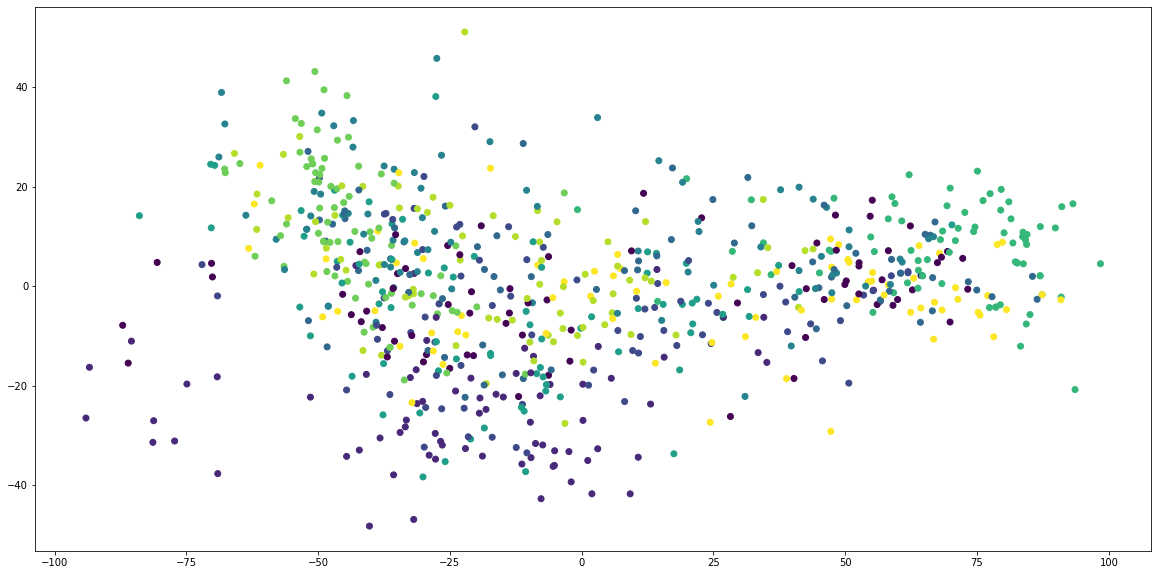

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y_train)
plt.show()

Guardamos los datos para tener una representación en: https://projector.tensorflow.org/

In [11]:
def obtener_nombre_genero(numero):
    generos = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    return generos[int(numero)]

with open('results/embedding-projector/records_before.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    for row in X_pca:
        writer.writerow(row)
    tsvfile.close() 

with open('results/embedding-projector/metadata_before.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(['ID', 'GENERO'])
    for row in y_train:
        writer.writerow([row, obtener_nombre_genero(row)])
    tsvfile.close()

FileNotFoundError: [Errno 2] No such file or directory: 'results/embedding-projector/records_before.tsv'

Calcularemos el PCA con el modelo ya entrenado

In [ ]:
from keras.models import model_from_json, Model

with open('../results/best-model/model.json') as f:
    config_model = f.read()
    
model = model_from_json(config_model)
model.load_weights('../results/best-model/weights.hdf5')

new_model = Model(model.inputs, model.layers[-3].output)
new_model.set_weights(model.get_weights())

In [ ]:
embedding = new_model.predict(X_train)

In [ ]:
pca = PCA(n_components = 350)
embedding_350 = pca.fit_transform(embedding)

with open('../results/embedding-projector/records.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    for row in embedding_350:
        writer.writerow(row)
    tsvfile.close() 
    
with open('../results/embedding-projector/metadata.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(['ID', 'GENERO'])
    for row in y_train:
        writer.writerow([row, obtener_nombre_genero(row)])
    tsvfile.close()

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(embedding_350[:,0], embedding_350[:,1], c = y_train)
plt.show()

Como se puede observar nuestro modelo ha conseguido agrupar los datos, por lo que se obtendrán buenos valores de clasificación